# Generating Synthetic Financial Time Series for Classification

This notebook focuses on generating time-series for predicting a recession.

Segments of code adapted from Gretel.ai example: https://github.com/gretelai/gretel-synthetics/blob/13ed0830769bb3c86627e46930ec0c5fbd5d76eb/examples/timeseries_dgan.ipynb

In [1]:
%%capture
!pip install torch numpy pandas matplotlib scikit-learn fredapi gretel-synthetics statsmodels

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import torch
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [3]:
# DoppelGANger requires multiple samples, so split up full series into samples with length equal to samp_size
samp_size = 30
# set last date for training data (this time period has 4 recessions)
last_train_date = '12-31-1984'

In [4]:
# get raw data from Fred (pulled in a different notebook outside of repository, requires API key)
# note: column names are FRED codes
df = pd.read_csv("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/fred_data_raw", 
                 index_col = 0, parse_dates = True)

# list of variables that are in Fred DataFrame
var_names = list(df.columns)

# create fixed attributes
# label what example number each row will be assigned to
df['example_num'] = np.divmod(np.arange(len(df)),samp_size)[0]+1
# indicator for whether or not recession occurred in that example
recess_indic = df.groupby('example_num').max('USRECD')['USRECD']

# specify # of days into future to look for recession
n_future = 250

# create indicator for whether or not a recession occurs in the next n_future (business) days
df_counter = df.copy().reset_index()
rec_future = list()
for i in range(len(df)):
  subset = df_counter.loc[i:i+n_future, 'USRECD']
  rec_max = subset.max()
  rec_future.append(rec_max)
del df_counter
df['rec_future'] = rec_future
future_recess_indic = df.groupby('example_num').max('rec_future')['rec_future']
# filter out current recessions from future_recess_indic
future_recess_indic[recess_indic == 1] = 0

df = df.drop(columns = ['example_num', 'rec_future'])

# split up training data
train_df = df[df.index <= last_train_date]

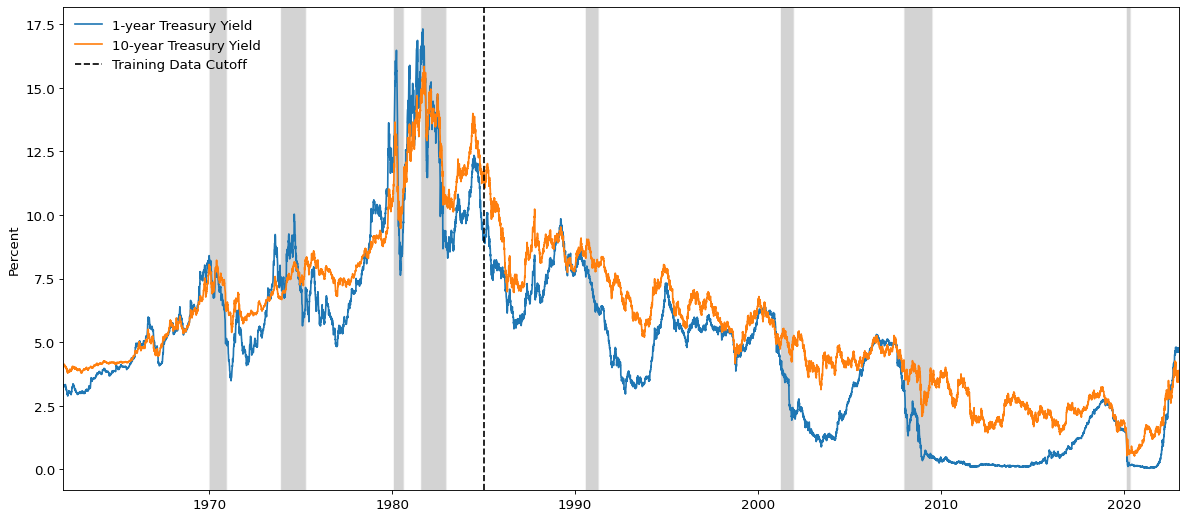

In [5]:
# set font
plt.rcParams.update({'font.size': 12})

#filter out recession dates
recessions = df.index[df['USRECD'] == 1]
graph_labels = ['1-year Treasury Yield', '10-year Treasury Yield', 'Training Data Cutoff']

# plot data
plt.figure(figsize=(18, 8), dpi=80)
for c in var_names[0:2]:
    plt.plot(df.index, df[c], label=c)
plt.axvline(dt.datetime.strptime(last_train_date, '%m-%d-%Y'), 
            label = 'Training Data Cutoff', color = 'black', linestyle = 'dashed')
#plot recession bars
for day in recessions:
    plt.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.1)
plt.legend(labels = graph_labels, frameon = False, loc = 'upper left')
plt.ylabel('Percent')
plt.xlim(df.index[0], df.index[-1])
#plt.savefig('/content/drive/MyDrive/Figures/real_data_classifier.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

In [6]:
# split time-series into many samples of size = samp_size and create array of features
# drop all fixed attributes from data
features = train_df.drop(columns=['USRECD']).to_numpy()
n = features.shape[0] // samp_size
features = features[:(n*samp_size),:].reshape(-1, samp_size, features.shape[1])
# shape of features array is (# examples, # time points, # features)
print(features.shape)

(191, 30, 2)


In [7]:
# NEED FIXED ATTRIBUTES (should not vary within each sample)
# create array of fixed attributes (recess_indic and future_recess_indic)
attributes = recess_indic.to_numpy()
attributes = np.stack([attributes, future_recess_indic.to_numpy()], axis = 1)
# ensure # of examples matches the # of examples in features array
attributes = attributes[:features.shape[0]]
attributes = attributes.reshape(attributes.shape[0], -1)
print(attributes.shape)

(191, 2)


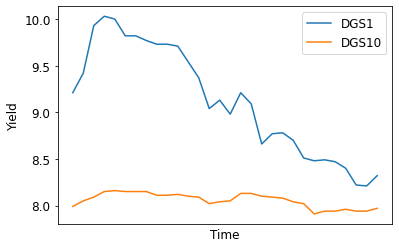

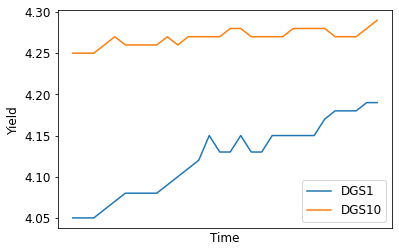

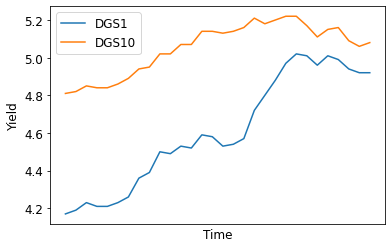

In [8]:
# display a few of the training samples
xaxis_days = np.array(range(1,samp_size+1))

def plot_day(f):
    for i, c in enumerate(var_names[0:2]):
        plt.plot(xaxis_days, f[:,i], label=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(2,24,3)))
    ax.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Yield")
    plt.show()

plot_day(features[105,:,:])
plot_day(features[30,:,:])
plot_day(features[45,:,:])

# Train DoppelGANger or load previous model

**Option to load a previously trained model**

In [ ]:
# load previously trained model if available, otherwise train below
if torch.cuda.is_available() == True:
  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained_classifier.pt')
else:
  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained_classifier.pt', map_location = torch.device('cpu'))

**Only run the cell below if want to train a new model, rather than load a pretrained model**

In [ ]:
# configure DGAN
model = DGAN(DGANConfig(
    # length of training examples and of generated synthetic data
    max_sequence_len=features.shape[1],
    # max_sequence_len / sample_len should be an integer between 10-20 for best results
    sample_len= 3,
    # default # of layers is 1
    feature_num_layers = 1,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=True,
    use_attribute_discriminator=True,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=3000,
))

# train model
model.train_numpy(
    attributes = attributes,
    features = features,
    feature_types= [OutputType.CONTINUOUS] * features.shape[2],
    attribute_types = [OutputType.DISCRETE] * attributes.shape[1]
)

In [ ]:
# save model
# model.save('/content/drive/MyDrive/Models/DGAN_trained_classifier.pt')

**Generate new synthetic data or load synthetic data used in paper**

In [9]:
# if True, uses pre-generated synthetic data from paper
paper_synth_data = True

In [11]:
if paper_synth_data:
  # read in data from DGAN_generation_classifier
  df = pd.read_csv("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/fred_data_classifier", 
                   index_col = 0, parse_dates = True)
  synthetic_attributes = np.loadtxt("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/synthetic_attributes_classifier")
  print(synthetic_attributes.shape)
  synthetic_features = np.loadtxt("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/synthetic_features_reshaped_classifier")
  synthetic_features = synthetic_features.reshape(50000, 30, 2)
  print(synthetic_features.shape)
else:
  synthetic_attributes, synthetic_features = model.generate_numpy(50000)

(50000, 2)
(50000, 30, 2)


## Fidelity Metrics

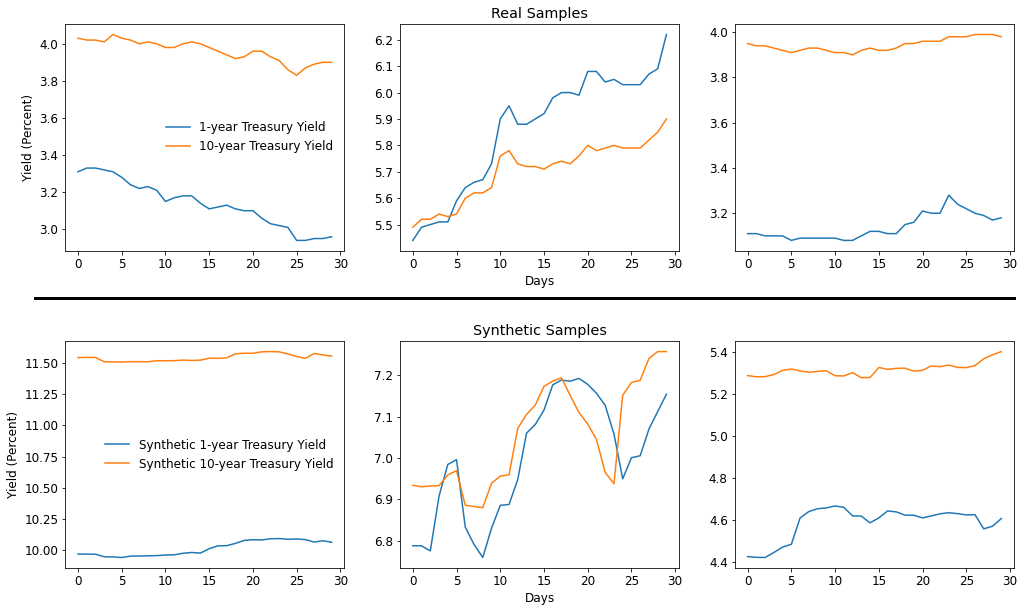

In [12]:
# create grid for plots
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(17)
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))
plt.subplots_adjust(hspace=0.4)

# plot 3x3 examples
ax1.plot(features[1,:,:])
ax2.plot(features[52,:,:])
ax3.plot(features[11,:,:])
ax4.plot(synthetic_features[88,:,:])
ax5.plot(synthetic_features[526,:,:])
ax6.plot(synthetic_features[24,:,:])
ax1.legend(['1-year Treasury Yield', '10-year Treasury Yield'],
           frameon = False)
ax1.set(ylabel = 'Yield (Percent)')
ax2.set(xlabel = 'Days', title = 'Real Samples')
ax4.plot([0.1, 0.9], [0.5, 0.5], color='black', lw=3,
         transform=plt.gcf().transFigure, clip_on=False)
ax4.legend(['Synthetic 1-year Treasury Yield', 'Synthetic 10-year Treasury Yield'],
           frameon = False)
ax4.set(ylabel = 'Yield (Percent)')
ax5.set(xlabel = 'Days', title = 'Synthetic Samples')
#fig.savefig('/content/drive/MyDrive/Figures/samples_compare_classifier.pdf', format = 'pdf', bbox_inches = 'tight')
fig.show()

Recession Indicator: [1. 0.]


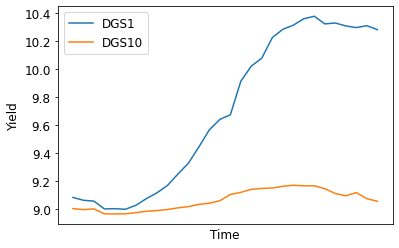

In [14]:
# pull random synthetic sample for viewing
lookup_num = np.random.randint(0, 50000)
print(f'Recession Indicator: {synthetic_attributes[lookup_num,:]}')
plot_day(synthetic_features[lookup_num,:,:])

Recession Indicator: [0. 0.]


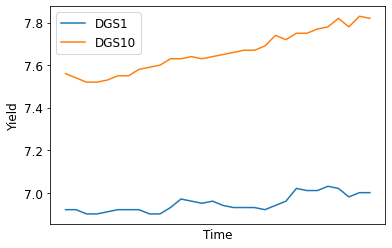

In [15]:
# pull random real sample for viewing
lookup_num = np.random.randint(0, features.shape[0])
print(f'Recession Indicator: {attributes[lookup_num,:]}')
plot_day(features[lookup_num,:,:])

In [16]:
# look at correlations between variables
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=var_names[0:2])

print("Correlation in real data:")
print(train_df.iloc[:,0:2].corr())
print()
print("Correlation in synthetic data:")
print(synthetic_df.corr())

Correlation in real data:
           DGS1     DGS10
DGS1   1.000000  0.950294
DGS10  0.950294  1.000000

Correlation in synthetic data:
          DGS1    DGS10
DGS1   1.00000  0.95325
DGS10  0.95325  1.00000


In [17]:
# set colors to compare real and synthetic
compare_colors = ['tomato', 'cadetblue']

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


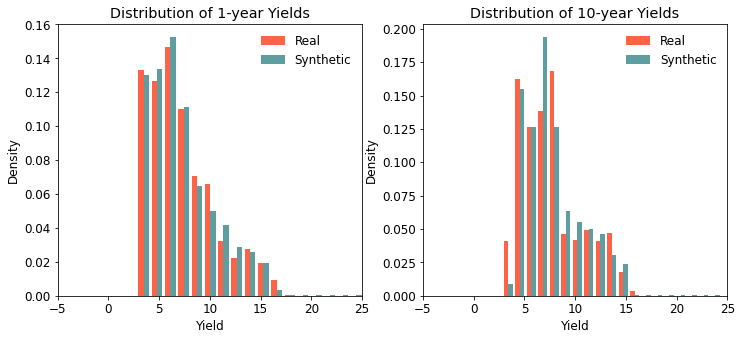

In [18]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
plt.subplots_adjust(wspace= 0.2)

# Compare distribution of 1 year yields
ax1.hist([features[:,:,0].flatten(), synthetic_features[:,:,0].flatten()], 
         label=["Real", "Synthetic"],
         bins=25,
         density=True,
         color = compare_colors)
ax2.hist([features[:,:,1].flatten(), synthetic_features[:,:,1].flatten()], 
         label=["Real", "Synthetic"],
         bins=25,
         density=True,
         color = compare_colors)
ax1.legend(frameon = False)
ax2.legend(frameon = False)
ax1.set(xlabel = "Yield", ylabel = "Density", xlim = [-5, 25],
        title = 'Distribution of 1-year Yields')
ax2.set(xlabel = "Yield", ylabel = "Density", xlim = [-5, 25],
        title = 'Distribution of 10-year Yields')
#fig.savefig('/content/drive/MyDrive/Figures/compare_hist_classifier.pdf', format = 'pdf', bbox_inches = 'tight')
fig.show()

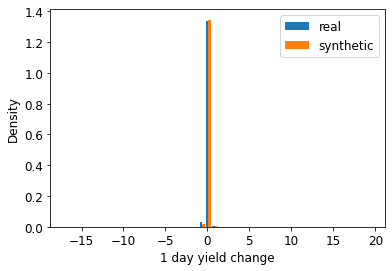

In [19]:
# Compare distribution of 1-step change for 10 year yield
real_diffs = np.diff(features, axis=1)
synthetic_diffs = np.diff(synthetic_features, axis=1)

plt.hist([real_diffs[:,:,0].flatten(), synthetic_diffs[:,:,0].flatten()],
         label=["real", "synthetic"],
         bins=50,
         density=True)
plt.legend()
plt.xlabel("1 day yield change")
plt.ylabel("Density")
#plt.xlim([-1.5, 1.5])
plt.show()

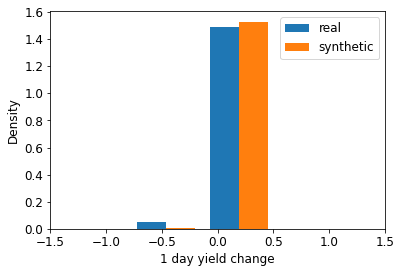

In [20]:
# Compare distribution of 1-step change for 1 year yield
real_diffs = np.diff(features, axis=1)
synthetic_diffs = np.diff(synthetic_features, axis=1)

plt.hist([real_diffs[:,:,1].flatten(), synthetic_diffs[:,:,1].flatten()],
         label=["real", "synthetic"],
         bins=50,
         density=True)
plt.legend()
plt.xlabel("1 day yield change")
plt.ylabel("Density")
plt.xlim([-1.5, 1.5])
plt.show()

In [21]:
# get average autocorrelation across all synthetic replicates
def get_synth_autocorr(synth_np, column_num, nlags):
  # filter on single variable in synth_np based on column_num
  synth_var = synth_np[:,:,column_num]
  # get autocorrelation values for each synthetic sample
  autocorr_vals = np.apply_along_axis(sm.tsa.acf, 1, synth_var, 
                                      fft = True, nlags = nlags)
  # average autocorrelation values across samples
  return(np.apply_along_axis(np.mean, 0, autocorr_vals))

# set number of desired lags
lags = 30

# get synthetic autocorrelations for both variables
synth_auto_1 = get_synth_autocorr(synthetic_features, 0, nlags = lags)
synth_auto_10 = get_synth_autocorr(synthetic_features, 1, nlags = lags)

# get true autocorrelations from features
features_auto_1 = get_synth_autocorr(features, 0, nlags = lags)
features_auto_10 = get_synth_autocorr(features, 1, nlags = lags)

# get true autocorrelations for both variables
true_auto_1 = sm.tsa.acf(train_df['DGS1'], nlags = lags, fft = True)
true_auto_10 = sm.tsa.acf(train_df['DGS10'], nlags = lags, fft = True)

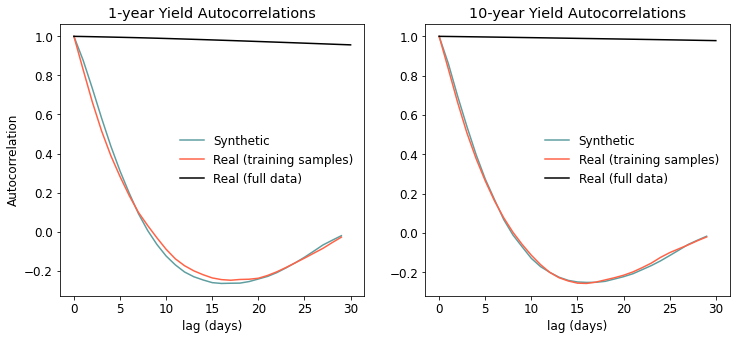

In [22]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

#plot autocorrelations for 1 year and synthetic
ax1.plot(synth_auto_1, label = 'Synthetic', color = compare_colors[1])
ax1.plot(features_auto_1, label = 'Real (training samples)', color = compare_colors[0])
ax1.plot(true_auto_1, label = 'Real (full data)', color = 'black')
ax1.set(title = '1-year Yield Autocorrelations', xlabel = 'lag (days)', ylabel = 'Autocorrelation')
ax1.legend(frameon = False)

#plot autocorrelations for 1 year and synthetic
ax2.plot(synth_auto_10, label = 'Synthetic', color = compare_colors[1])
ax2.plot(features_auto_10, label = 'Real (training samples)', color = compare_colors[0])
ax2.plot(true_auto_10, label = 'Real (full data)', color = 'black')
ax2.set(title = '10-year Yield Autocorrelations', xlabel = 'lag (days)')
ax2.legend(frameon = False)
#fig.savefig('/content/drive/MyDrive/Figures/autocorr_classifier.pdf', format = 'pdf', bbox_inches = 'tight')
fig.show()

## Examples for saving data

In [ ]:
# save and output data to drive
#df.to_csv("/content/drive/MyDrive/Synthetic_data/fred_data_classifier")
#np.savetxt("/content/drive/MyDrive/Synthetic_data/synthetic_attributes_classifier", synthetic_attributes)

In [ ]:
# reshape multidimensional numpy arrays so they can be saved (must return to original shape when loading)
#print(f'synthetic_features original shape: {synthetic_features.shape}')
#synthetic_features_reshape = synthetic_features.reshape(synthetic_features.shape[0], -1)
#np.savetxt("/content/drive/MyDrive/Synthetic_data/synthetic_features_reshaped_classifier", synthetic_features_reshape)

synthetic_features original shape: (50000, 30, 2)


In [ ]:
#### example for loading and reshaping
# test = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_features_reshaped_classifier")
# test_orig = test.reshape(1000, 30, 2)
# (test_orig == synthetic_features).all()